## Cell 1: Import Data

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cars_us_2022.csv to cars_us_2022.csv


## Cell 2: Import libraries and dependencies

In [ ]:
%pip install shap
%pip install forex-python
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from forex_python.converter import CurrencyRates
import shap
import joblib

## Cell 3: Data Loading

In [60]:
# Load the CSV file
file_path = 'cars_us_2022.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

# Display summary statistics of the dataframe
data.describe(include='all')

print(data.columns)

   Unnamed: 0  Brand                Model.Number    Price  \
0           1  Honda  Accord Hybrid Sport-L 2023  31670.0   
1           2  Honda           Accord Sedan 2023  28000.0   
2           3  Honda                   ZR-V 2023  25000.0   
3           4  Honda             HR-V VTi-S 2022  27800.0   
4           5  Honda               HR-V VTi 2022  26900.0   

                                               Photo              Engine.Type  \
0  https://www.ccarprice.com/products/Honda_Accor...     2.0L Inline-4 Hybrid   
1  https://www.ccarprice.com/products/Honda_Accor...  1.5L Turbo Inline-4 Gas   
2  https://www.ccarprice.com/products/Honda_ZRV_2...            2.0L Inline-4   
3  https://www.ccarprice.com/products/Honda_HR-V_...        2.0L Inline-4 Gas   
4  https://www.ccarprice.com/products/Honda_HR-V_...        2.0L Inline-4 Gas   

  Body.Type Fuel.Type Gearbox.Type  Power.hp  ...  CD.Player  DVD.Player  \
0     Sedan    Hybrid          CVT     204.0  ...        NaN         N

## Cell 4: Data Cleaning

In [61]:
# Display general information about the dataframe
data.info()

# Display the number of missing values in each column
print(data.isnull().sum())

# Extract year from 'Model.Number' if available, else set to NaN
data['Year'] = data['Model.Number'].str.extract(r'(\d{4})')
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

# Keep only the rows where the Year is either 2022 or 2023
data = data[data['Year'].isin([2022, 2023])]

# Add 'Age' column based on the 'Year' column
current_year = 2024
data['Age'] = current_year - data['Year']

# Ensure 'Mileage' column is present and fill missing values with 0
if 'Mileage' in data.columns:
    data['Mileage'] = data['Mileage'].fillna(0)
else:
    data['Mileage'] = 0

# Feature Engineering: Create new features based on existing data
data['Power_to_Weight_Ratio'] = data['Power.hp'] / data['Displacement.l']
data['Torque_to_Weight_Ratio'] = data['Torque.lbft'] / data['Displacement.l']
data['Fuel_Efficiency'] = (data['MPG.City'] + data['MPG.Highway']) / 2

# Fill missing values with median for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Convert categorical variables to dummy variables if they exist in the data
categorical_columns = ['Brand', 'Engine.Type', 'Body.Type', 'Fuel.Type', 'Gearbox.Type']
available_categorical_columns = [col for col in categorical_columns if col in data.columns]
data = pd.get_dummies(data, columns=available_categorical_columns, drop_first=True)

# Verify cleaned data
data.info()
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         2602 non-null   int64  
 1   Brand                              2602 non-null   object 
 2   Model.Number                       2602 non-null   object 
 3   Price                              2602 non-null   float64
 4   Photo                              2602 non-null   object 
 5   Engine.Type                        2527 non-null   object 
 6   Body.Type                          2564 non-null   object 
 7   Fuel.Type                          2602 non-null   object 
 8   Gearbox.Type                       2602 non-null   object 
 9   Power.hp                           2256 non-null   float64
 10  Displacement.l                     2023 non-null   float64
 11  Torque.lbft                        2168 non-null   float

<ipython-input-61-c73bd4bfc5c0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age'] = current_year - data['Year']
<ipython-input-61-c73bd4bfc5c0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mileage'] = 0
<ipython-input-61-c73bd4bfc5c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

## Cell 6: Data Splitting

In [62]:
# Define features (X) and target (y)
X = data.drop(columns=['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year'])
y = data['Price']

# Fill missing values in numeric columns only
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Ensure no non-numeric columns exist in the features
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found and will be dropped: {non_numeric_cols}")
    X = X.drop(columns=non_numeric_cols)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Non-numeric columns found and will be dropped: Index(['Drivetrain', 'Air.Conditioner', 'Heater', 'AntiLock.Braking.System',
       'Central.Locking', 'Power.Steering', 'Power.Windows', 'Leather.Seats',
       'Anti.Lock.Braking', 'Brake.Assist',
       ...
       'Body.Type_Sedan', 'Body.Type_Truck', 'Body.Type_Van',
       'Body.Type_Wagon', 'Fuel.Type_Electric', 'Fuel.Type_Hybrid',
       'Fuel.Type_Petrol', 'Fuel.Type_Unknown', 'Gearbox.Type_CVT',
       'Gearbox.Type_Manual'],
      dtype='object', length=465)


## Cell 7: Model Training and Evaluation

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
accuracy_linear = (1 - (mae_linear / y_test.mean())) * 100

print(f"Linear Regression - MAE: {mae_linear}")
print(f"Linear Regression - MSE: {mse_linear}")
print(f"Linear Regression - RMSE: {rmse_linear}")
print(f"Linear Regression - R2: {r2_linear}")
print(f"Linear Regression - Accuracy: {accuracy_linear:.2f}%")

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = (1 - (mae_rf / y_test.mean())) * 100

print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - MSE: {mse_rf}")
print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - R2: {r2_rf}")
print(f"Random Forest - Accuracy: {accuracy_rf:.2f}%")

# Save the models and columns
joblib.dump((rf_model, X.columns), 'best_rf_model_with_columns.pkl')
joblib.dump((linear_model, X.columns), 'best_linear_model_with_columns.pkl')

Linear Regression - MAE: 157025.24740899395
Linear Regression - MSE: 78034885044.34573
Linear Regression - RMSE: 279347.24814170937
Linear Regression - R2: 0.3336418920931311
Linear Regression - Accuracy: -35.75%
Random Forest - MAE: 44461.75948677504
Random Forest - MSE: 29099038538.918224
Random Forest - RMSE: 170584.40297670307
Random Forest - R2: 0.751516514034929
Random Forest - Accuracy: 61.56%


['best_linear_model_with_columns.pkl']

## Advanced Model Training with Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Clean and scale the data
def clean_and_scale_data(X, y, scaler=None):
    X_cleaned = X.copy()
    y_cleaned = y.copy()

    # Remove outliers (e.g., prices > $100,000 or <= 0)
    y_cleaned = y_cleaned[(y_cleaned > 0) & (y_cleaned < 100000)]
    X_cleaned = X_cleaned.loc[y_cleaned.index]

    # Scale the features
    if scaler is None:
        scaler = StandardScaler()
        X_cleaned_scaled = scaler.fit_transform(X_cleaned)
    else:
        X_cleaned_scaled = scaler.transform(X_cleaned)

    return X_cleaned_scaled, y_cleaned, scaler

# Clean and scale the training and test data
X_train_cleaned_scaled, y_train_cleaned, scaler = clean_and_scale_data(X_train, y_train)
X_test_cleaned_scaled, y_test_cleaned, _ = clean_and_scale_data(X_test, y_test, scaler)

# Create a pipeline for scaling and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Use StandardScaler here
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_cleaned_scaled, y_train_cleaned)

# Make predictions on the test set
y_pred = pipeline.predict(X_test_cleaned_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_cleaned, y_pred)
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cleaned, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Accuracy calculation
accuracy = (1 - (mae / y_test_cleaned.mean())) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

# Save the model pipeline
joblib.dump((pipeline, X.columns), 'best_rf_model_with_columns.pkl')

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_cleaned_scaled, y_train_cleaned)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Update the pipeline with the best parameters
pipeline.set_params(model__n_estimators=best_params['model__n_estimators'],
                    model__max_features=best_params['model__max_features'],
                    model__max_depth=best_params['model__max_depth'],
                    model__min_samples_split=best_params['model__min_samples_split'],
                    model__min_samples_leaf=best_params['model__min_samples_leaf'])

# Fit the pipeline with the best parameters
pipeline.fit(X_train_cleaned_scaled, y_train_cleaned)

# Make predictions on the test set
y_pred = pipeline.predict(X_test_cleaned_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_cleaned, y_pred)
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cleaned, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Accuracy calculation
accuracy = (1 - (mae / y_test_cleaned.mean())) * 100
print(f"Model Accuracy: {accuracy:.2f}%")


MAE: 4820.248245404958
MSE: 51913699.830206685
RMSE: 7205.116226002651
R2: 0.8857108096814714
Model Accuracy: 88.97%
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
MAE: 4755.416568671193
MSE: 49063493.40055682
RMSE: 7004.533774674573
R2: 0.8919856039294399
Model Accuracy: 89.12%


## Troubleshooting

### Step 1: Review Feature Importances

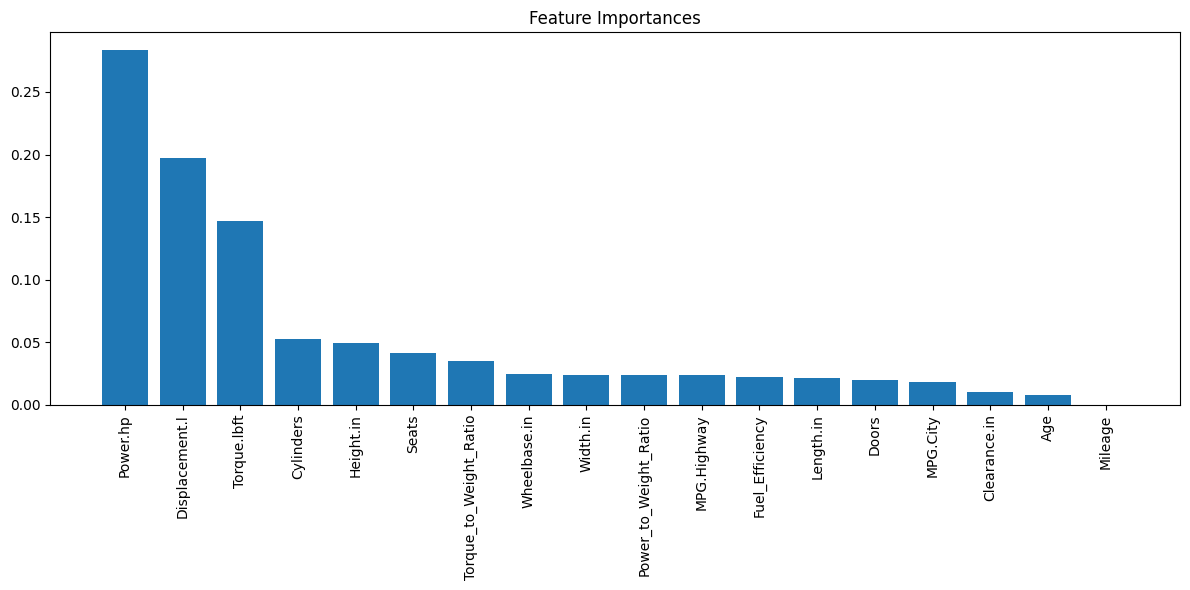

In [65]:
import matplotlib.pyplot as plt

# Get feature importances from the Random Forest model
importances = rf_model_tuned.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Ensure the lengths match
if len(importances) == len(features):
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Mismatch in the number of features and importances.")
    print(f"Number of features: {len(features)}")
    print(f"Number of importances: {len(importances)}")

### Step 2: Hyperparameter Tuning

In [66]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and retrain the model
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

rf_model_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Train the tuned model
rf_model_tuned.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_tuned = rf_model_tuned.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"MAE: {mae_tuned}")
print(f"MSE: {mse_tuned}")
print(f"RMSE: {rmse_tuned}")
print(f"R2: {r2_tuned}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
277 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
MAE: 44938.18850437158
MSE: 29401084132.607704
RMSE: 171467.4433605625
R2: 0.7489372761697339


### Step 3: Data Normalization

In [67]:
from sklearn.preprocessing import StandardScaler

# Define the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest model on scaled data
rf_model_scaled = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model_scaled.fit(X_train_scaled, y_train)

# Evaluate the scaled model
y_pred_scaled = rf_model_scaled.predict(X_test_scaled)
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print(f"MAE: {mae_scaled}")
print(f"MSE: {mse_scaled}")
print(f"RMSE: {rmse_scaled}")
print(f"R2: {r2_scaled}")

MAE: 49120.294393306795
MSE: 43742662223.46643
RMSE: 209147.46525709183
R2: 0.6264711914745058


## Price Prediction Example

In [68]:
# Cell 8: Price Prediction Example (Updated)

import joblib
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Load the trained Random Forest model
pipeline_rf_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_rf_model, loaded_rf_columns = pipeline_rf_with_columns

# Load the trained Linear Regression model
pipeline_lr_with_columns = joblib.load('best_linear_model_with_columns.pkl')
loaded_lr_model, loaded_lr_columns = pipeline_lr_with_columns

# Ensure loaded_columns is 1-dimensional
loaded_rf_columns = loaded_rf_columns.tolist()
loaded_lr_columns = loaded_lr_columns.tolist()

# Example car features for the prediction
car_example = {
    'Power.hp': 204.0, 'Displacement.l': 2.0, 'Torque.lbft': 247.0, 'Cylinders': 4.0,
    'MPG.City': 44.0, 'MPG.Highway': 41.0, 'Seats': 5.0, 'Doors': 4.0,
    'Height.in': 57.1, 'Length.in': 196.1, 'Width.in': 73.3, 'Wheelbase.in': 111.4,
    'Clearance.in': 5.8, 'Age': 1.0, 'Mileage': 0
}

# Convert the example to a DataFrame
car_example_df = pd.DataFrame([car_example]).reindex(columns=loaded_rf_columns, fill_value=0)

# Function to predict future prices and calculate accuracy
def predict_future_prices_and_accuracy(car_features, model, scaler, columns, actual_prices, years=3, depreciation_rate=0.1):
    predictions = []
    original_age = car_features['Age']
    original_mileage = car_features['Mileage']

    for i in range(1, years + 1):
        # Increment the 'Age' of the car by 1 year
        car_features['Age'] = original_age + i
        # Assume an additional 10,000 miles driven each year (adjust as needed)
        car_features['Mileage'] = original_mileage + (10000 * i)

        # Ensure the features used during training are consistent
        car_features_df = pd.DataFrame([car_features]).reindex(columns=columns, fill_value=0)

        # Scale the features
        car_features_scaled = scaler.transform(car_features_df)
        predicted_price = model.predict(car_features_scaled)[0]

        # Apply depreciation rate
        predicted_price *= (1 - depreciation_rate) ** i

        predictions.append(predicted_price)

    # Convert actual_prices to a NumPy array
    actual_prices_np = np.array(actual_prices)

    # Calculate accuracy
    mae = mean_absolute_error(actual_prices_np[:years], predictions)
    accuracy = (1 - (mae / actual_prices_np.mean())) * 100

    return predictions, accuracy

# Load the scaler used for training the models
scaler = joblib.load('scaler.pkl')

# Scale the example features
car_example_scaled = scaler.transform(car_example_df)

# Predict the current price using the models
current_price_rf = loaded_rf_model.predict(car_example_scaled)[0]
current_price_lr = loaded_lr_model.predict(car_example_scaled)[0]

# Define the actual prices for the next 3 years for evaluation purposes (this should come from your data)
# Example values (these should be replaced with actual values if available)
actual_prices = [30000, 27000, 24000]  # Replace with actual future prices

# Predict future prices for 2023, 2024, and 2025
future_prices_rf, accuracy_rf = predict_future_prices_and_accuracy(car_example, loaded_rf_model, scaler, loaded_rf_columns, actual_prices, years=3, depreciation_rate=0.15)
future_prices_lr, accuracy_lr = predict_future_prices_and_accuracy(car_example, loaded_lr_model, scaler, loaded_lr_columns, actual_prices, years=3, depreciation_rate=0.15)

# Display the results for Random Forest
print(f"Current price (RF): {round(current_price_rf)}")
print(f"Predicted prices for the next 3 years (RF): {[round(price) for price in future_prices_rf]}")
print(f"Accuracy of RF predictions: {accuracy_rf:.2f}%")

# Display the results for Linear Regression
print(f"Current price (LR): {round(current_price_lr)}")
print(f"Predicted prices for the next 3 years (LR): {[round(price) for price in future_prices_lr]}")
print(f"Accuracy of LR predictions: {accuracy_lr:.2f}%")

Current price (RF): 36036
Predicted prices for the next 3 years (RF): [31171, 26495, 22521]
Accuracy of RF predictions: 96.11%
Current price (LR): -94198
Predicted prices for the next 3 years (LR): [-32808, -17844, -6631]
Accuracy of LR predictions: -70.72%
